# Option Pricing

This notebook demonstrates option pricing using multiple methods:
- Black-Scholes analytical pricing
- Binomial tree pricing
- Monte Carlo simulation
- Greeks calculation

We'll compare the results and analyze the trade-offs between accuracy and computational speed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dervflow import BlackScholesModel, BinomialTreeModel, MonteCarloOptionPricer, GreeksCalculator
import time

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Define Option Parameters

Let's price a European call option with the following parameters:

In [2]:
# Option parameters
spot = 100.0
strike = 100.0
rate = 0.05
dividend = 0.02
volatility = 0.25
time_to_maturity = 1.0
option_type = 'call'

print(f"Spot Price: ${spot}")
print(f"Strike Price: ${strike}")
print(f"Risk-free Rate: {rate*100}%")
print(f"Dividend Yield: {dividend*100}%")
print(f"Volatility: {volatility*100}%")
print(f"Time to Maturity: {time_to_maturity} years")
print(f"Option Type: {option_type.upper()}")

Spot Price: $100.0
Strike Price: $100.0
Risk-free Rate: 5.0%
Dividend Yield: 2.0%
Volatility: 25.0%
Time to Maturity: 1.0 years
Option Type: CALL


## 2. Black-Scholes Analytical Pricing

The Black-Scholes model provides a closed-form solution for European options.

In [3]:
# Black-Scholes pricing
bs_model = BlackScholesModel()

start_time = time.time()
bs_price = bs_model.price(spot, strike, rate, dividend, volatility, time_to_maturity, option_type)
bs_time = time.time() - start_time

print(f"Black-Scholes Price: ${bs_price:.4f}")
print(f"Computation Time: {bs_time*1000:.4f} ms")

Black-Scholes Price: $11.1238
Computation Time: 0.4478 ms


## 3. Binomial Tree Pricing

Binomial trees provide a discrete-time approximation that converges to Black-Scholes as the number of steps increases.

In [4]:
# Binomial tree pricing with different step counts
tree_model = BinomialTreeModel()
step_counts = [10, 50, 100, 200, 500]
tree_prices = []
tree_times = []

for steps in step_counts:
    start_time = time.time()
    price = tree_model.price(spot, strike, rate, dividend, volatility, time_to_maturity, steps, 'european', option_type)
    elapsed = time.time() - start_time
    tree_prices.append(price)
    tree_times.append(elapsed)
    print(f"Steps: {steps:4d} | Price: ${price:.4f} | Error: ${abs(price - bs_price):.4f} | Time: {elapsed*1000:.2f} ms")

print(f"\nBlack-Scholes Reference: ${bs_price:.4f}")

Steps:   10 | Price: $10.8853 | Error: $0.2384 | Time: 0.19 ms
Steps:   50 | Price: $11.0755 | Error: $0.0482 | Time: 0.01 ms
Steps:  100 | Price: $11.0996 | Error: $0.0241 | Time: 0.02 ms
Steps:  200 | Price: $11.1117 | Error: $0.0121 | Time: 0.05 ms
Steps:  500 | Price: $11.1189 | Error: $0.0048 | Time: 0.23 ms

Black-Scholes Reference: $11.1238


### Convergence Analysis

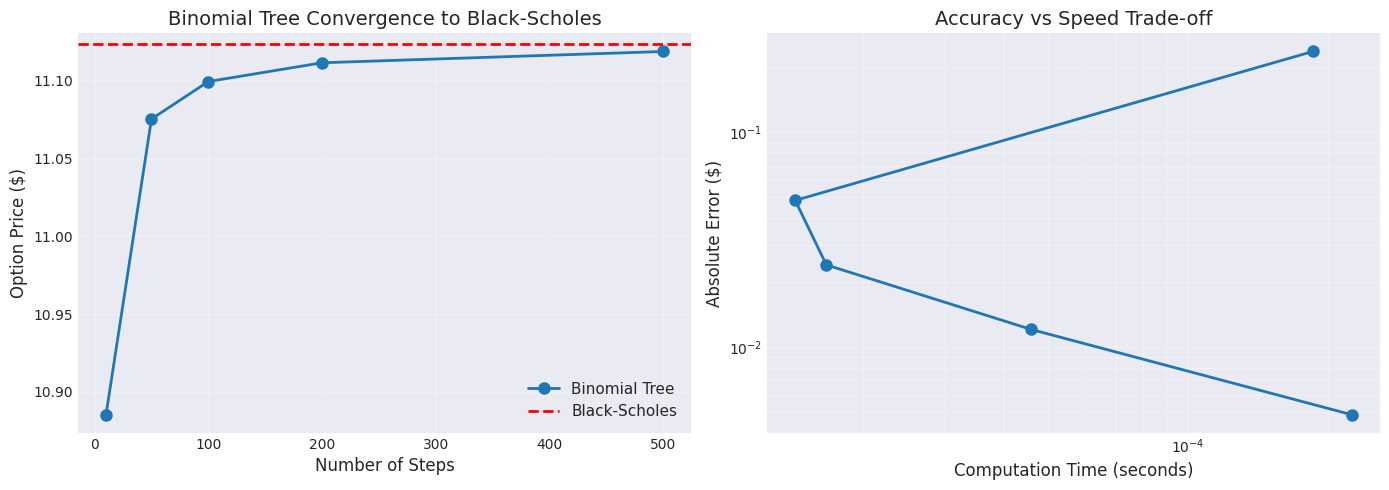

In [5]:
# Plot convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Price convergence
ax1.plot(step_counts, tree_prices, 'o-', label='Binomial Tree', linewidth=2, markersize=8)
ax1.axhline(y=bs_price, color='r', linestyle='--', label='Black-Scholes', linewidth=2)
ax1.set_xlabel('Number of Steps', fontsize=12)
ax1.set_ylabel('Option Price ($)', fontsize=12)
ax1.set_title('Binomial Tree Convergence to Black-Scholes', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Error vs computation time
errors = [abs(p - bs_price) for p in tree_prices]
ax2.loglog(tree_times, errors, 'o-', linewidth=2, markersize=8)
ax2.set_xlabel('Computation Time (seconds)', fontsize=12)
ax2.set_ylabel('Absolute Error ($)', fontsize=12)
ax2.set_title('Accuracy vs Speed Trade-off', fontsize=14)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## 4. Monte Carlo Simulation

Monte Carlo methods simulate many price paths and average the discounted payoffs.

In [6]:
# Monte Carlo pricing with different path counts
mc_pricer = MonteCarloOptionPricer()
path_counts = [1000, 5000, 10000, 50000, 100000]
mc_prices = []
mc_std_errors = []
mc_times = []

for paths in path_counts:
    start_time = time.time()
    result = mc_pricer.price_european(spot, strike, rate, dividend, volatility, time_to_maturity, option_type, paths, use_antithetic=True)
    elapsed = time.time() - start_time
    
    price = result['price']
    std_error = result['std_error']
    mc_prices.append(price)
    mc_std_errors.append(std_error)
    mc_times.append(elapsed)
    
    print(f"Paths: {paths:6d} | Price: ${price:.4f} ± ${std_error:.4f} | Error: ${abs(price - bs_price):.4f} | Time: {elapsed*1000:.2f} ms")

print(f"\nBlack-Scholes Reference: ${bs_price:.4f}")

Paths:   1000 | Price: $11.1214 ± $0.5598 | Error: $0.0024 | Time: 3.13 ms
Paths:   5000 | Price: $10.8047 ± $0.2430 | Error: $0.3191 | Time: 2.55 ms
Paths:  10000 | Price: $10.9036 ± $0.1708 | Error: $0.2201 | Time: 4.86 ms
Paths:  50000 | Price: $11.0618 ± $0.0781 | Error: $0.0620 | Time: 31.24 ms
Paths: 100000 | Price: $11.0902 ± $0.0551 | Error: $0.0335 | Time: 48.10 ms

Black-Scholes Reference: $11.1238


### Monte Carlo Convergence

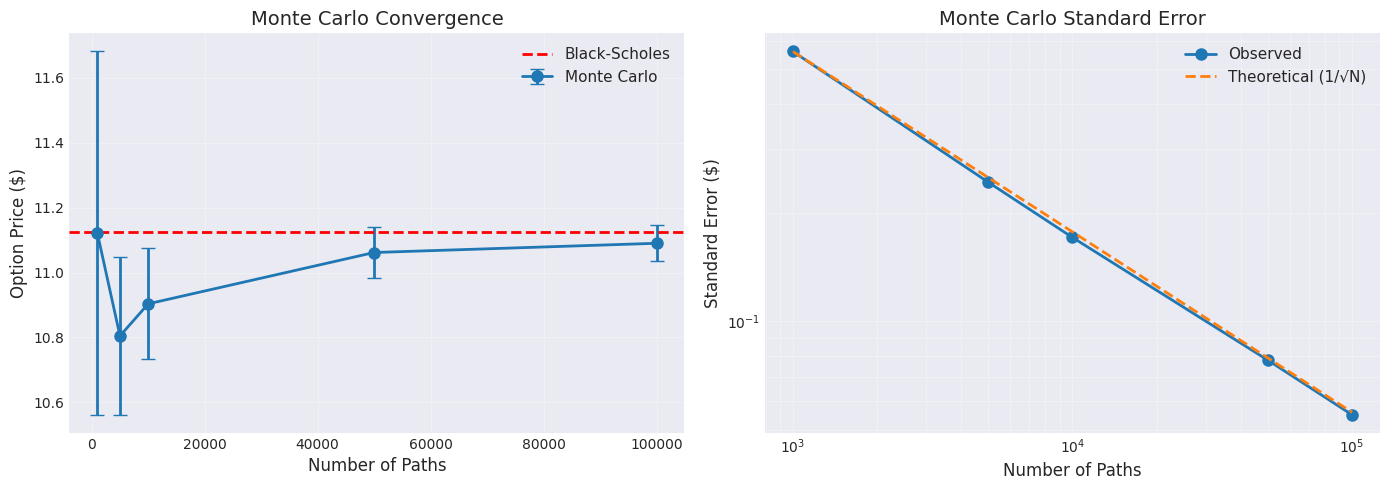

In [7]:
# Plot Monte Carlo convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Price with error bars
ax1.errorbar(path_counts, mc_prices, yerr=mc_std_errors, fmt='o-', capsize=5, linewidth=2, markersize=8, label='Monte Carlo')
ax1.axhline(y=bs_price, color='r', linestyle='--', label='Black-Scholes', linewidth=2)
ax1.set_xlabel('Number of Paths', fontsize=12)
ax1.set_ylabel('Option Price ($)', fontsize=12)
ax1.set_title('Monte Carlo Convergence', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Standard error vs sqrt(N)
ax2.loglog(path_counts, mc_std_errors, 'o-', linewidth=2, markersize=8, label='Observed')
theoretical = mc_std_errors[0] * np.sqrt(path_counts[0] / np.array(path_counts))
ax2.loglog(path_counts, theoretical, '--', linewidth=2, label='Theoretical (1/√N)')
ax2.set_xlabel('Number of Paths', fontsize=12)
ax2.set_ylabel('Standard Error ($)', fontsize=12)
ax2.set_title('Monte Carlo Standard Error', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## 5. Method Comparison

Let's compare all three methods side by side.


Method Comparison:
                  Method     Price    Error  Time (ms)  Std Error
           Black-Scholes 11.123758 0.000000   0.447750   0.000000
    Binomial (500 steps) 11.118927 0.004831   0.225782   0.000000
Monte Carlo (100k paths) 11.090214 0.033544  48.102856   0.055079


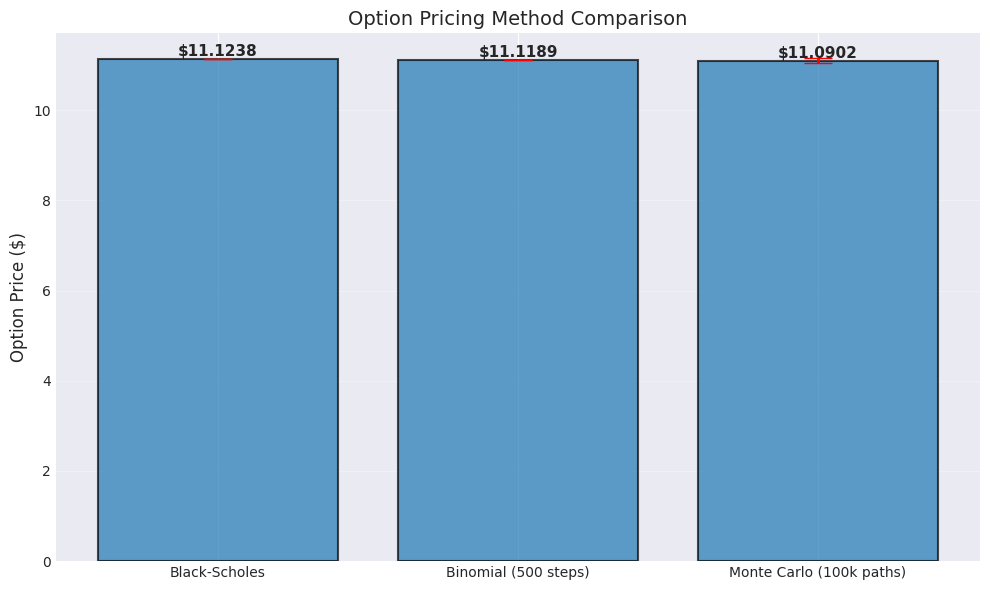

In [8]:
# Create comparison table
comparison_data = {
    'Method': ['Black-Scholes', 'Binomial (500 steps)', 'Monte Carlo (100k paths)'],
    'Price': [bs_price, tree_prices[-1], mc_prices[-1]],
    'Error': [0.0, abs(tree_prices[-1] - bs_price), abs(mc_prices[-1] - bs_price)],
    'Time (ms)': [bs_time*1000, tree_times[-1]*1000, mc_times[-1]*1000],
    'Std Error': [0.0, 0.0, mc_std_errors[-1]]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nMethod Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
methods = comparison_df['Method']
prices = comparison_df['Price']
errors = comparison_df['Std Error']

bars = ax.bar(methods, prices, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.errorbar(methods, prices, yerr=errors, fmt='none', ecolor='red', capsize=10, linewidth=2)
ax.set_ylabel('Option Price ($)', fontsize=12)
ax.set_title('Option Pricing Method Comparison', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, price in zip(bars, prices):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${price:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Greeks Calculation

Greeks measure the sensitivity of option prices to various parameters.

In [9]:
# Calculate Greeks using analytical method
greeks_calc = GreeksCalculator()
greeks = bs_model.greeks(spot, strike, rate, dividend, volatility, time_to_maturity, option_type)

print("Option Greeks:")
print(f"Delta:   {greeks['delta']:.4f}  (∂V/∂S)")
print(f"Gamma:   {greeks['gamma']:.4f}  (∂²V/∂S²)")
print(f"Vega:    {greeks['vega']:.4f}  (∂V/∂σ)")
print(f"Theta:   {greeks['theta']:.4f}  (∂V/∂t)")
print(f"Rho:     {greeks['rho']:.4f}  (∂V/∂r)")

Option Greeks:
Delta:   0.5850  (∂V/∂S)
Gamma:   0.0152  (∂²V/∂S²)
Vega:    0.3795  (∂V/∂σ)
Theta:   -0.0097  (∂V/∂t)
Rho:     0.4737  (∂V/∂r)


### Visualize Greeks Across Strike Prices

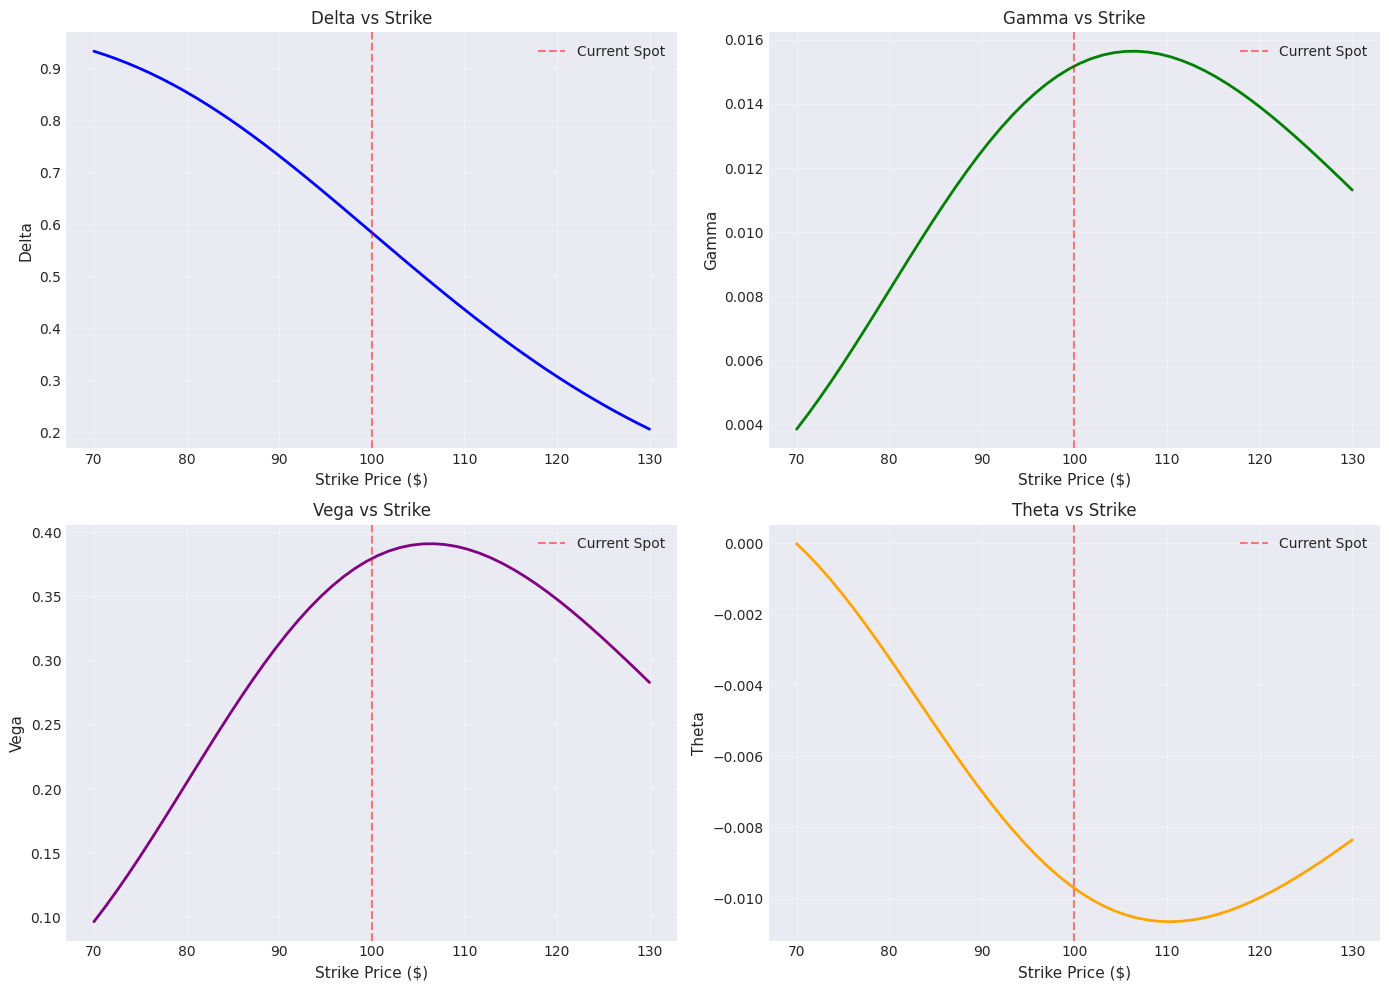

In [10]:
# Calculate Greeks for a range of strikes
strikes = np.linspace(70, 130, 50)
deltas = []
gammas = []
vegas = []
thetas = []

for K in strikes:
    g = bs_model.greeks(spot, K, rate, dividend, volatility, time_to_maturity, option_type)
    deltas.append(g['delta'])
    gammas.append(g['gamma'])
    vegas.append(g['vega'])
    thetas.append(g['theta'])

# Plot Greeks
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

ax1.plot(strikes, deltas, linewidth=2, color='blue')
ax1.axvline(x=spot, color='red', linestyle='--', alpha=0.5, label='Current Spot')
ax1.set_xlabel('Strike Price ($)', fontsize=11)
ax1.set_ylabel('Delta', fontsize=11)
ax1.set_title('Delta vs Strike', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(strikes, gammas, linewidth=2, color='green')
ax2.axvline(x=spot, color='red', linestyle='--', alpha=0.5, label='Current Spot')
ax2.set_xlabel('Strike Price ($)', fontsize=11)
ax2.set_ylabel('Gamma', fontsize=11)
ax2.set_title('Gamma vs Strike', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

ax3.plot(strikes, vegas, linewidth=2, color='purple')
ax3.axvline(x=spot, color='red', linestyle='--', alpha=0.5, label='Current Spot')
ax3.set_xlabel('Strike Price ($)', fontsize=11)
ax3.set_ylabel('Vega', fontsize=11)
ax3.set_title('Vega vs Strike', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.legend()

ax4.plot(strikes, thetas, linewidth=2, color='orange')
ax4.axvline(x=spot, color='red', linestyle='--', alpha=0.5, label='Current Spot')
ax4.set_xlabel('Strike Price ($)', fontsize=11)
ax4.set_ylabel('Theta', fontsize=11)
ax4.set_title('Theta vs Strike', fontsize=12)
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

## 7. American vs European Options

Compare American and European option prices using binomial trees.

In [11]:
# Price American put option (early exercise premium)
put_type = 'put'
steps = 200

european_put = tree_model.price(spot, strike, rate, dividend, volatility, time_to_maturity, steps, 'european', put_type)
american_put = tree_model.price(spot, strike, rate, dividend, volatility, time_to_maturity, steps, 'american', put_type)

early_exercise_premium = american_put - european_put

print(f"European Put Price: ${european_put:.4f}")
print(f"American Put Price: ${american_put:.4f}")
print(f"Early Exercise Premium: ${early_exercise_premium:.4f}")
print(f"Premium as % of European: {(early_exercise_premium/european_put)*100:.2f}%")

European Put Price: $8.2148
American Put Price: $8.5588
Early Exercise Premium: $0.3441
Premium as % of European: 4.19%
